In [2]:
import csv
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import losses,optimizers,models,layers,regularizers
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
IMG_WIDTH=256
IMG_HEIGHT=256
BATCH_SIZE=16
NUM_EPOCHS=50
CLASS_NAMES=['barcode','both','qr']
MODEL_PATH='models/'
MODEL_NAME='model'
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

In [5]:
dataset_path = '/kaggle/input/barcode-and-qr'

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=404,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    label_mode='categorical',
    shuffle=True
)

Found 992 files belonging to 3 classes.
Using 794 files for training.


In [8]:
qr_ds = train_ds.filter(lambda x, y: tf.reduce_any(y[:, 1:3] == 1))
qr_ds = qr_ds.map(lambda x, y: (x, tf.where(tf.reduce_any(y[:, 1:3] == 1, axis=1), 1, 0)))

barcode_ds = train_ds.filter(lambda x, y: tf.reduce_any(y[:, 0:2] == 1))
barcode_ds = barcode_ds.map(lambda x, y: (x, tf.where(tf.reduce_any(y[:, 0:2] == 1, axis=1), 1, 0)))

In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=404,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    label_mode='categorical',
    shuffle=True
)

Found 992 files belonging to 3 classes.
Using 198 files for validation.


In [11]:
val_qr_ds = val_ds.filter(lambda x, y: tf.reduce_any(y[:, 1:3] == 1))
val_qr_ds = val_qr_ds.map(lambda x, y: (x, tf.where(tf.reduce_any(y[:, 1:3] == 1, axis=1), 1, 0)))

val_barcode_ds = val_ds.filter(lambda x, y: tf.reduce_any(y[:, 0:2] == 1))
val_barcode_ds = val_barcode_ds.map(lambda x, y: (x, tf.where(tf.reduce_any(y[:, 0:2] == 1, axis=1), 1, 0)))

In [14]:
for image_batch,labels_batch in qr_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
for image_batch,labels_batch in barcode_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 256, 256, 3)
(16,)
(16, 256, 256, 3)
(16,)


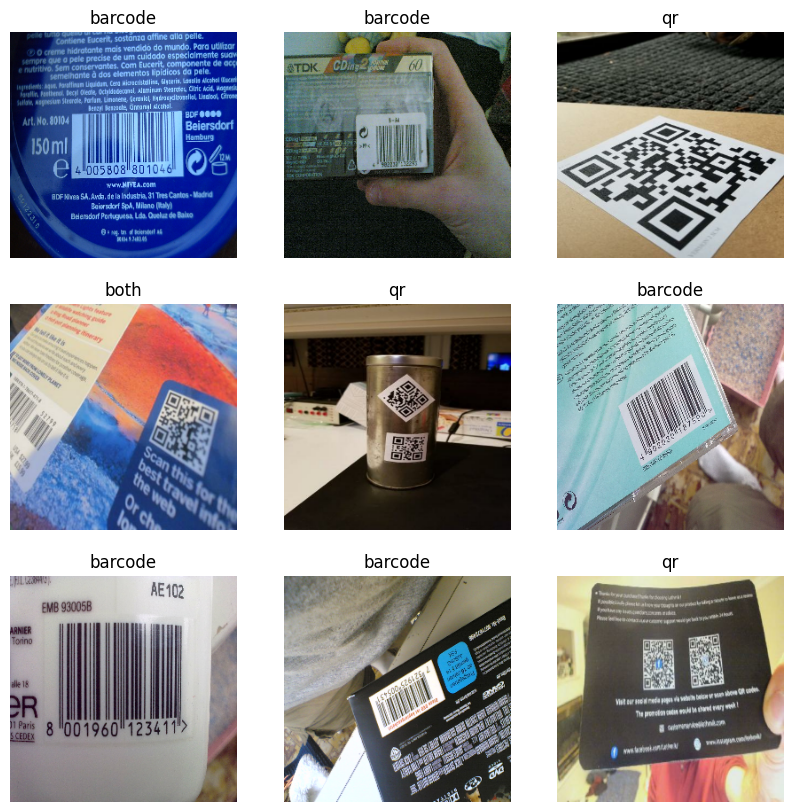

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[np.argmax(labels[i])])
        plt.axis("off")


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

qr_ds = qr_ds.cache().prefetch(buffer_size=AUTOTUNE)
barcode_ds = barcode_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_qr_ds = val_qr_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_barcode_ds = val_barcode_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
])

In [19]:
qr_model = tf.keras.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

barcode_model = tf.keras.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [20]:
qr_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)    

In [21]:
barcode_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_2 (Batc  (None, 254, 254, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_3 (Batc  (None, 125, 125, 64)    

In [22]:
qr_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                loss=losses.BinaryCrossentropy(),
                metrics=['binary_accuracy'])

barcode_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                loss=losses.BinaryCrossentropy(),
                metrics=['binary_accuracy'])

In [23]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=10, verbose=1, restore_best_weights=True),
]

In [24]:
qr_history = qr_model.fit(
    qr_ds,
    validation_data=val_qr_ds,
    epochs=NUM_EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
50/50 [==============================] - 15s 125ms/step - loss: 1.8818 - binary_accuracy: 0.7620 - val_loss: 3.7175 - val_binary_accuracy: 0.7222
Epoch 2/50
50/50 [==============================] - 2s 37ms/step - loss: 0.8421 - binary_accuracy: 0.8501 - val_loss: 1.2947 - val_binary_accuracy: 0.8030
Epoch 3/50
50/50 [==============================] - 2s 37ms/step - loss: 0.6890 - binary_accuracy: 0.8489 - val_loss: 0.6552 - val_binary_accuracy: 0.9242
Epoch 4/50
50/50 [==============================] - 2s 33ms/step - loss: 0.8501 - binary_accuracy: 0.8627 - val_loss: 0.6319 - val_binary_accuracy: 0.8939
Epoch 5/50
50/50 [==============================] - 2s 34ms/step - loss: 0.6414 - binary_accuracy: 0.8892 - val_loss: 0.5462 - val_binary_accuracy: 0.8838
Epoch 6/50
50/50 [==============================] - 2s 34ms/step - loss: 0.5406 - binary_accuracy: 0.8992 - val_loss: 0.4771 - val_binary_accuracy: 0.9091
Epoch 7/50
50/50 [==============================] - 2s 33ms/step - l

In [25]:
barcode_history = barcode_model.fit(
    barcode_ds,
    validation_data=val_barcode_ds,
    epochs=NUM_EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
50/50 [==============================] - 7s 103ms/step - loss: 2.7640 - binary_accuracy: 0.6914 - val_loss: 1.8798 - val_binary_accuracy: 0.7273
Epoch 2/50
50/50 [==============================] - 2s 33ms/step - loss: 0.7953 - binary_accuracy: 0.7884 - val_loss: 1.2896 - val_binary_accuracy: 0.6515
Epoch 3/50
50/50 [==============================] - 2s 33ms/step - loss: 0.7391 - binary_accuracy: 0.7947 - val_loss: 0.9270 - val_binary_accuracy: 0.6919
Epoch 4/50
50/50 [==============================] - 2s 37ms/step - loss: 0.7180 - binary_accuracy: 0.8023 - val_loss: 0.7361 - val_binary_accuracy: 0.7424
Epoch 5/50
50/50 [==============================] - 2s 37ms/step - loss: 0.6881 - binary_accuracy: 0.7884 - val_loss: 0.7070 - val_binary_accuracy: 0.8030
Epoch 6/50
50/50 [==============================] - 2s 34ms/step - loss: 0.6150 - binary_accuracy: 0.8174 - val_loss: 0.9423 - val_binary_accuracy: 0.7475
Epoch 7/50
50/50 [==============================] - 2s 37ms/step - lo

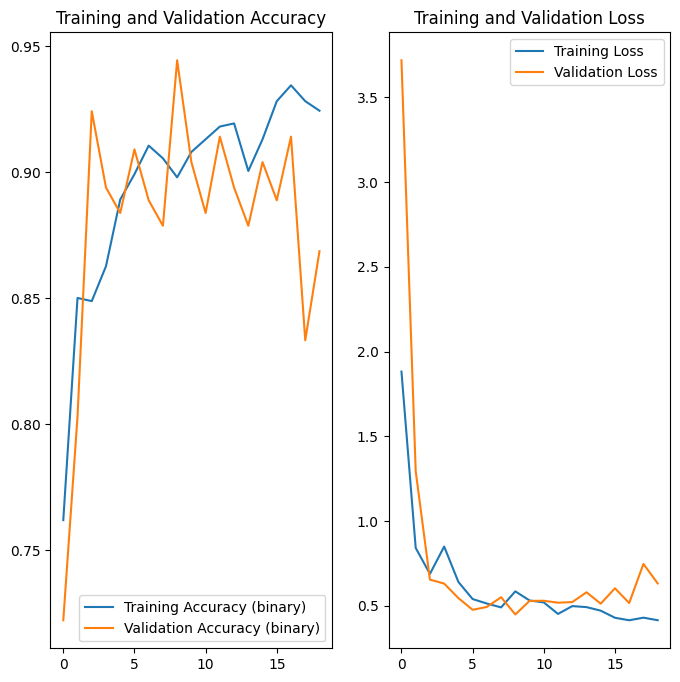

In [26]:
qr_acc = qr_history.history['binary_accuracy']
val_qr_acc = qr_history.history['val_binary_accuracy']

qr_loss = qr_history.history['loss']
val_qr_loss = qr_history.history['val_loss']

qr_epochs_range = qr_history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(qr_epochs_range, qr_acc, label='Training Accuracy (binary)')
plt.plot(qr_epochs_range, val_qr_acc, label='Validation Accuracy (binary)')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(qr_epochs_range, qr_loss, label='Training Loss')
plt.plot(qr_epochs_range, val_qr_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

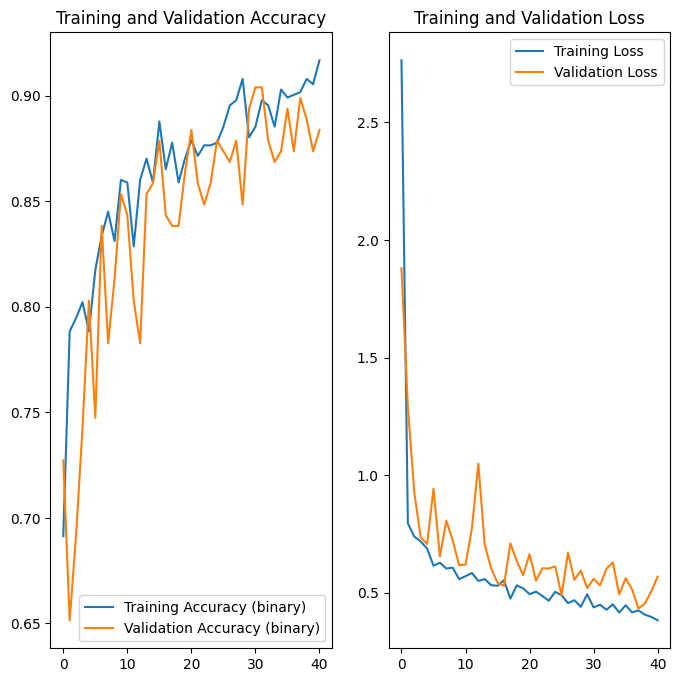

In [27]:
barcode_acc = barcode_history.history['binary_accuracy']
val_barcode_acc = barcode_history.history['val_binary_accuracy']

barcode_loss = barcode_history.history['loss']
val_barcode_loss = barcode_history.history['val_loss']

barcode_epochs_range = barcode_history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(barcode_epochs_range, barcode_acc, label='Training Accuracy (binary)')
plt.plot(barcode_epochs_range, val_barcode_acc, label='Validation Accuracy (binary)')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(barcode_epochs_range, barcode_loss, label='Training Loss')
plt.plot(barcode_epochs_range, val_barcode_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [28]:
input_layer = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

qr_output = qr_model(input_layer)
barcode_output = barcode_model(input_layer)

combined_output = layers.concatenate([qr_output, barcode_output], axis=-1)

combined_model = tf.keras.models.Model(inputs=input_layer, outputs=combined_output)

In [29]:
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 1)            31510081    ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 1)            31510081    ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 2)            0           ['sequential_1[0][0]',       

In [30]:
combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

26/26 [==============================] - 1s 14ms/step


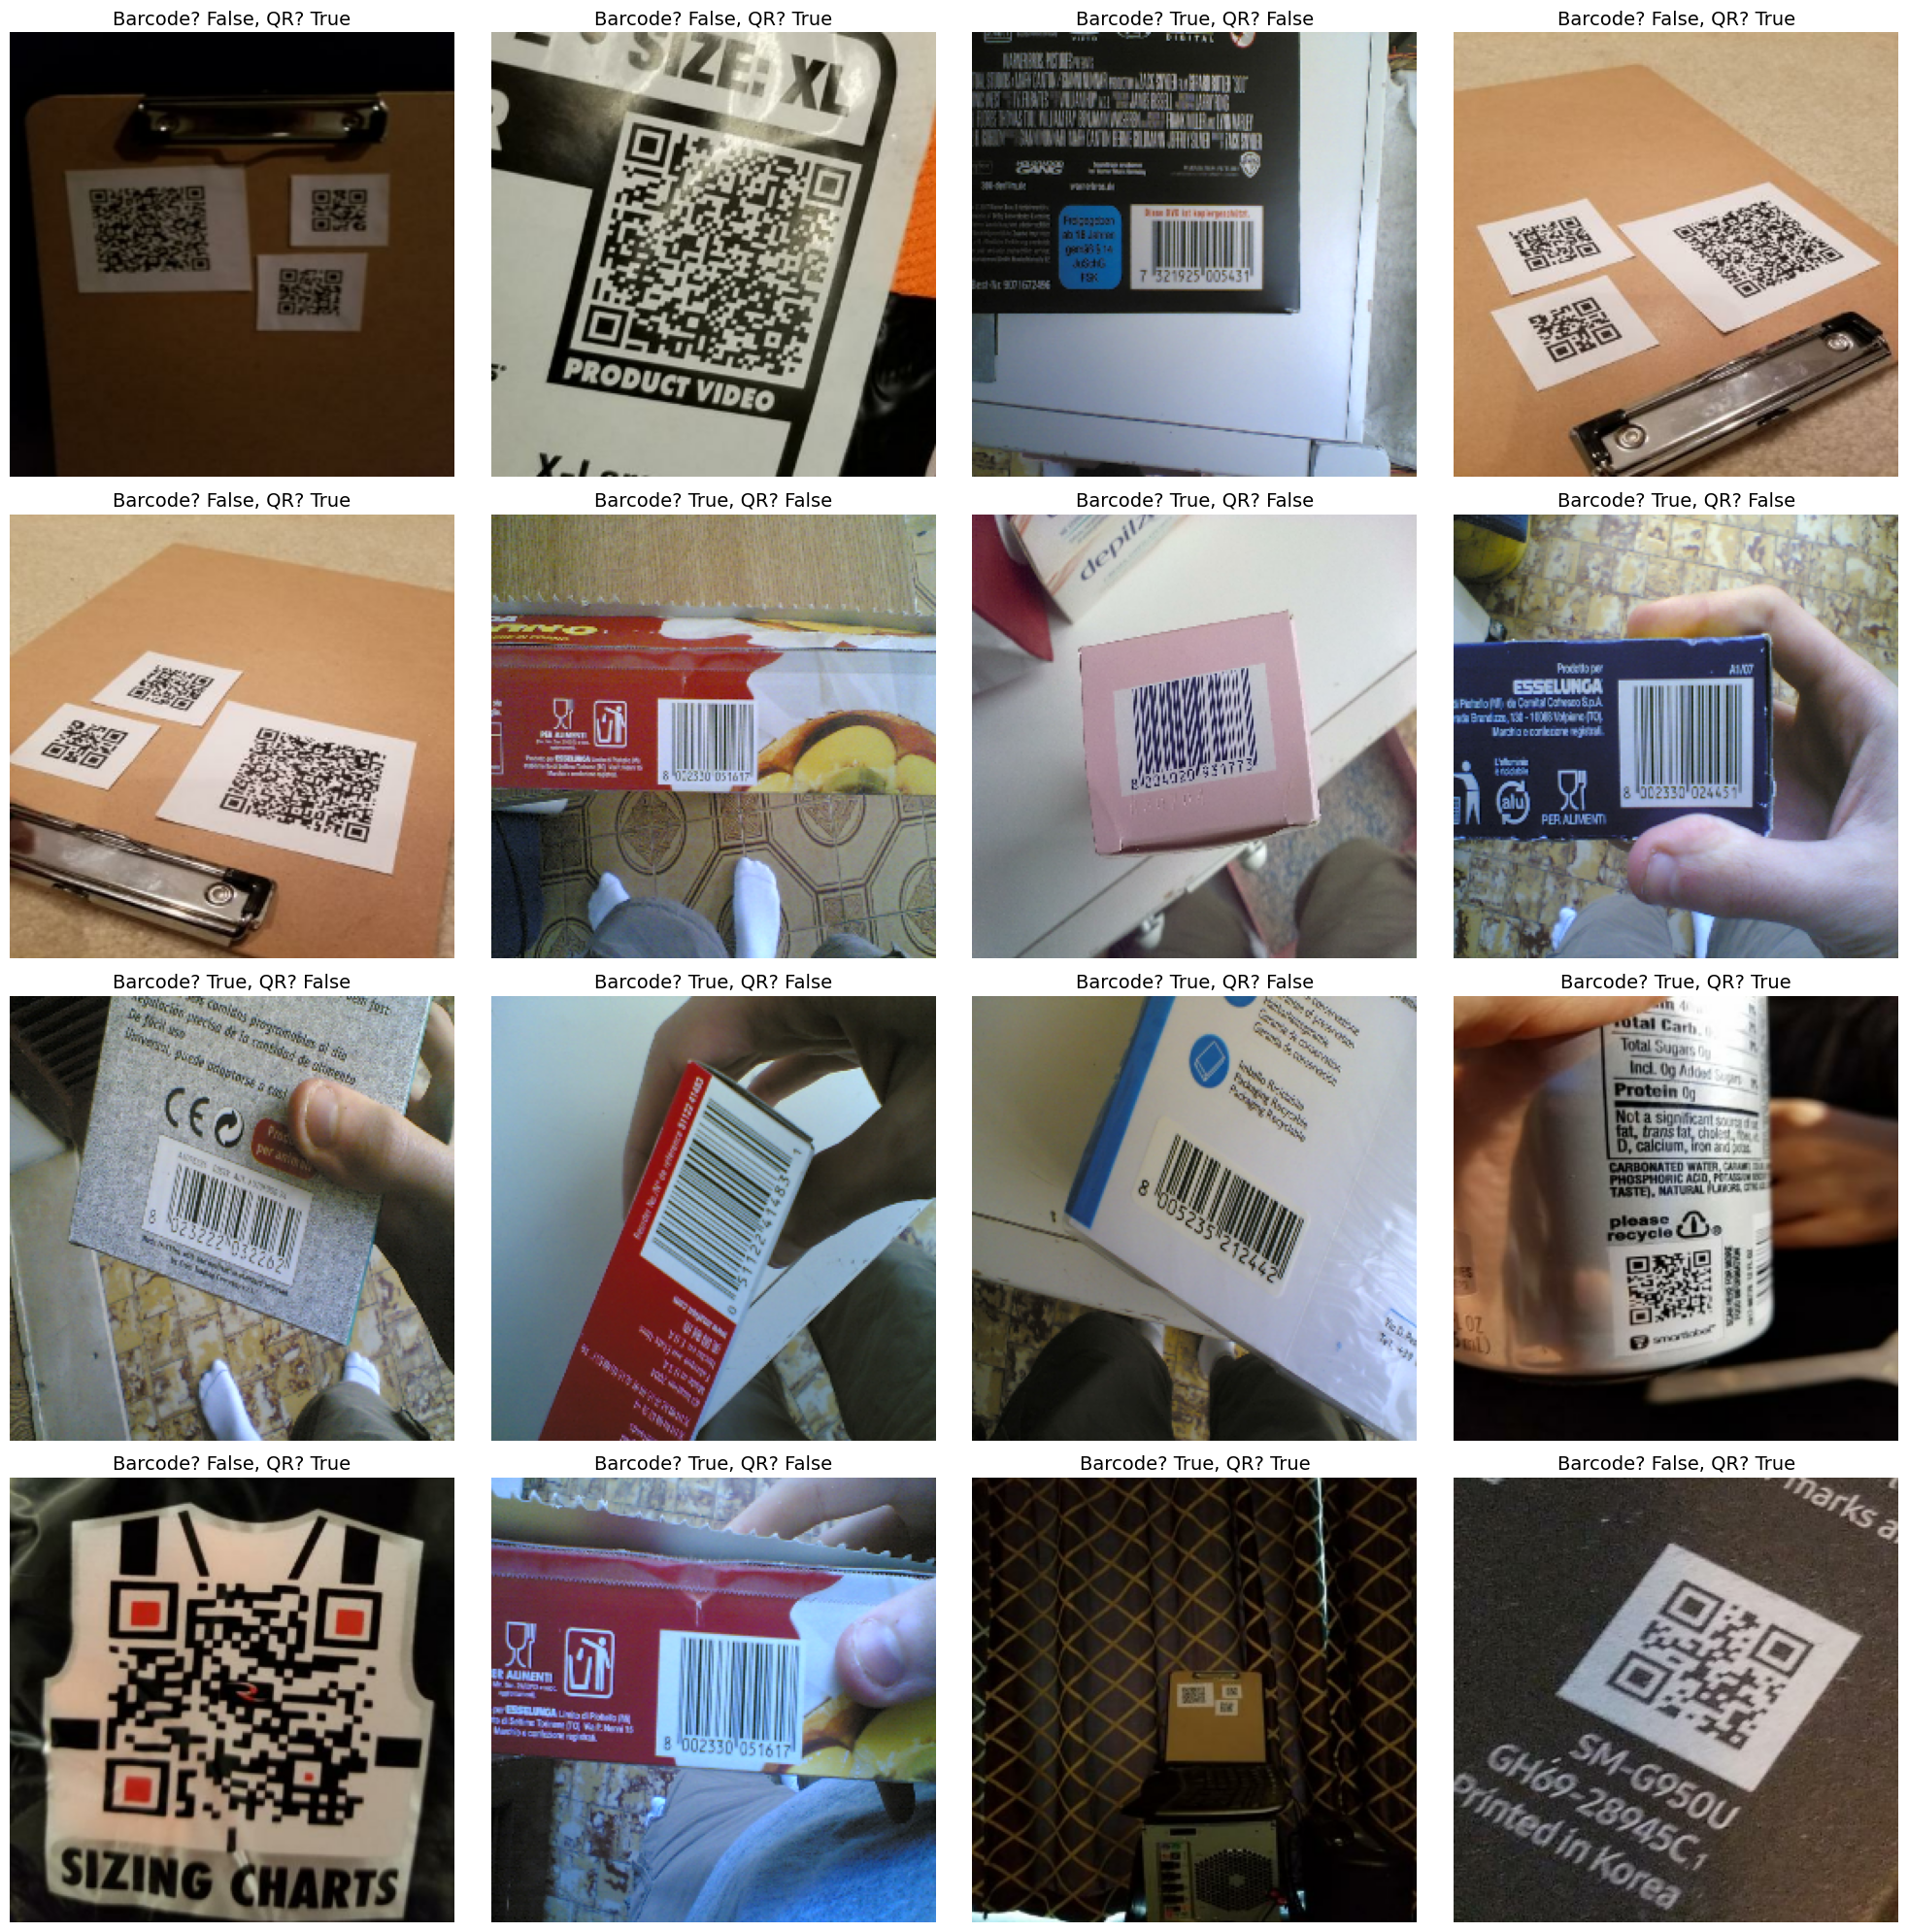

In [31]:
combined_ds = val_qr_ds.concatenate(val_barcode_ds)
predictions = combined_model.predict(combined_ds)

num_displayed_images = 0
max_display_images = 16

plt.figure(figsize=(20, 20))
for images, labels in combined_ds:
    for i in range(len(images)):
        if num_displayed_images >= max_display_images:
            break
        result = predictions[i]
        is_qr = result[0] > 0.5
        is_barcode = result[1] > 0.5
        output_text = f"Barcode? {is_barcode}, QR? {is_qr}"
        ax = plt.subplot(4, 4, num_displayed_images + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(output_text, fontsize=14)
        plt.axis("off")
        num_displayed_images += 1

    if num_displayed_images >= max_display_images:
        break
plt.tight_layout()
plt.show()